In [15]:
from collections import defaultdict
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
import xgboost as  xgb


In [16]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
ROWS_TO_PREDICT = 32
# one day 16 rows of data

In [17]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-03-16 04:00:00-04:00,159.880000,159.880000,156.110000,156.110000,156.110000,0
2020-03-16 05:00:00-04:00,156.110000,156.110000,154.000000,154.990000,154.990000,0
2020-03-16 06:00:00-04:00,154.680000,154.750000,153.480000,153.480000,153.480000,0
2020-03-16 07:00:00-04:00,153.500000,155.600000,153.030000,155.300000,155.300000,0
2020-03-16 08:00:00-04:00,155.060000,155.690000,153.480000,155.000000,155.000000,0
...,...,...,...,...,...,...
2021-03-15 14:30:00-04:00,274.929993,275.959991,273.279999,273.605011,273.605011,2279459
2021-03-15 15:30:00-04:00,273.589996,273.790009,272.299988,273.750000,273.750000,2141111
2021-03-15 16:00:00-04:00,273.750000,274.000000,262.240000,273.230000,273.230000,1005801


In [18]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-03-16 04:00:00-04:00,159.880000,159.880000,156.110000,156.110000,156.110000,0
2020-03-16 05:00:00-04:00,156.110000,156.110000,154.000000,154.990000,154.990000,0
2020-03-16 06:00:00-04:00,154.680000,154.750000,153.480000,153.480000,153.480000,0
2020-03-16 07:00:00-04:00,153.500000,155.600000,153.030000,155.300000,155.300000,0
2020-03-16 08:00:00-04:00,155.060000,155.690000,153.480000,155.000000,155.000000,0
2020-03-16 09:00:00-04:00,155.000000,155.850000,152.000000,152.200000,152.200000,0
2020-03-16 09:30:00-04:00,152.320007,152.419998,147.000000,151.020004,151.020004,8893083
2020-03-16 10:30:00-04:00,151.080002,155.860001,151.029999,154.339996,154.339996,4649153
2020-03-16 11:30:00-04:00,154.300003,159.130005,152.809998,155.880005,155.880005,4594218


<AxesSubplot:xlabel='Datetime'>

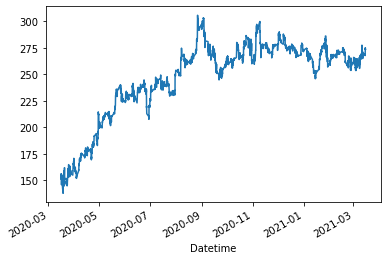

In [19]:
data['close'].plot()

In [20]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    # data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    # data['ema15'] = data['close'] / data['close'].ewm(ROWS_TO_PREDICT).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()
    for i in range(1,11):
        data[f'close{i}'] = data['close'].shift(i)
    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

In [21]:
data.head(15)

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,close1,close2,close3,close4,close5,close6,close7,close8,close9,close10
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-16 04:00:00-04:00,156.110000,NaN,0.000000,0.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 05:00:00-04:00,154.990000,0.000000,-0.025128,-0.013960,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 06:00:00-04:00,153.480000,0.000000,-0.078843,-0.040552,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 07:00:00-04:00,155.300000,43.458980,-0.035631,-0.038885,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,153.480000,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 08:00:00-04:00,155.000000,40.346411,-0.023338,-0.034260,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,155.300000,153.480000,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 09:00:00-04:00,152.200000,23.458834,-0.135239,-0.061631,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,155.000000,155.300000,153.480000,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN
2020-03-16 09:30:00-04:00,151.020004,19.713915,-0.258129,-0.111359,NaN,3.345313e+07,NaN,NaN,NaN,NaN,...,152.200000,155.000000,155.300000,153.480000,154.990000,156.110000,NaN,NaN,NaN,NaN
2020-03-16 10:30:00-04:00,154.339996,45.887974,-0.178482,-0.127490,NaN,4.737873e+07,NaN,NaN,NaN,NaN,...,151.020004,152.200000,155.000000,155.300000,153.480000,154.990000,156.110000,NaN,NaN,NaN
2020-03-16 11:30:00-04:00,155.880005,53.466238,-0.044206,-0.108251,NaN,5.912048e+07,NaN,NaN,NaN,NaN,...,154.339996,151.020004,152.200000,155.000000,155.300000,153.480000,154.990000,156.110000,NaN,NaN


In [22]:
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,close1,close2,close3,close4,close5,close6,close7,close8,close9,close10
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-16 04:00:00-04:00,156.110000,NaN,0.000000,0.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 05:00:00-04:00,154.990000,0.000000,-0.025128,-0.013960,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 06:00:00-04:00,153.480000,0.000000,-0.078843,-0.040552,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 07:00:00-04:00,155.300000,43.458980,-0.035631,-0.038885,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,153.480000,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16 08:00:00-04:00,155.000000,40.346411,-0.023338,-0.034260,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,155.300000,153.480000,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15 14:30:00-04:00,273.605011,63.294238,1.081043,0.408892,78.394658,7.008067e+09,2.004058,4.695011,89.900896,1.931678,...,274.920013,272.230011,271.950012,271.690002,271.880005,268.420000,267.550000,267.870000,268.390000,268.91
2021-03-15 15:30:00-04:00,273.750000,63.695367,1.200942,0.567302,79.724833,7.011115e+09,2.089060,5.360000,76.730559,1.940121,...,273.605011,274.920013,272.230011,271.950012,271.690002,271.880005,268.420000,267.550000,267.870000,268.39
2021-03-15 16:00:00-04:00,273.230000,61.115745,1.239712,0.701784,80.102091,7.022102e+09,2.726424,5.360000,71.848583,1.606485,...,273.750000,273.605011,274.920013,272.230011,271.950012,271.690002,271.880005,268.420000,267.550000,267.87


In [23]:
data.columns

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', '20 period CCI', 'VIm',
       'VIp', 'ema50', 'ema21', 'ema5', 'close1', 'close2', 'close3', 'close4',
       'close5', 'close6', 'close7', 'close8', 'close9', 'close10'],
      dtype='object')

In [24]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.2:
        return 1
    if row['close_shift'] -row['close']< -1.2:
        return -1
    else:
        return 0

In [25]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,close2,close3,close4,close5,close6,close7,close8,close9,close10,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-16 04:00:00-04:00,156.110000,NaN,0.000000,0.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.880005
2020-03-16 05:00:00-04:00,154.990000,0.000000,-0.025128,-0.013960,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.910004
2020-03-16 06:00:00-04:00,153.480000,0.000000,-0.078843,-0.040552,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.220001
2020-03-16 07:00:00-04:00,155.300000,43.458980,-0.035631,-0.038885,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.205002
2020-03-16 08:00:00-04:00,155.000000,40.346411,-0.023338,-0.034260,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,153.480000,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,145.960007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15 14:30:00-04:00,273.605011,63.294238,1.081043,0.408892,78.394658,7.008067e+09,2.004058,4.695011,89.900896,1.931678,...,272.230011,271.950012,271.690002,271.880005,268.420000,267.550000,267.870000,268.390000,268.91,NaN
2021-03-15 15:30:00-04:00,273.750000,63.695367,1.200942,0.567302,79.724833,7.011115e+09,2.089060,5.360000,76.730559,1.940121,...,274.920013,272.230011,271.950012,271.690002,271.880005,268.420000,267.550000,267.870000,268.39,NaN
2021-03-15 16:00:00-04:00,273.230000,61.115745,1.239712,0.701784,80.102091,7.022102e+09,2.726424,5.360000,71.848583,1.606485,...,273.605011,274.920013,272.230011,271.950012,271.690002,271.880005,268.420000,267.550000,267.87,NaN


In [26]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,close3,close4,close5,close6,close7,close8,close9,close10,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-16 04:00:00-04:00,156.110000,NaN,0.000000,0.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.880005,0
2020-03-16 05:00:00-04:00,154.990000,0.000000,-0.025128,-0.013960,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.910004,-1
2020-03-16 06:00:00-04:00,153.480000,0.000000,-0.078843,-0.040552,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.220001,-1
2020-03-16 07:00:00-04:00,155.300000,43.458980,-0.035631,-0.038885,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.205002,-1
2020-03-16 08:00:00-04:00,155.000000,40.346411,-0.023338,-0.034260,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,154.990000,156.110000,NaN,NaN,NaN,NaN,NaN,NaN,145.960007,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15 14:30:00-04:00,273.605011,63.294238,1.081043,0.408892,78.394658,7.008067e+09,2.004058,4.695011,89.900896,1.931678,...,271.950012,271.690002,271.880005,268.420000,267.550000,267.870000,268.390000,268.91,NaN,0
2021-03-15 15:30:00-04:00,273.750000,63.695367,1.200942,0.567302,79.724833,7.011115e+09,2.089060,5.360000,76.730559,1.940121,...,272.230011,271.950012,271.690002,271.880005,268.420000,267.550000,267.870000,268.39,NaN,0
2021-03-15 16:00:00-04:00,273.230000,61.115745,1.239712,0.701784,80.102091,7.022102e+09,2.726424,5.360000,71.848583,1.606485,...,274.920013,272.230011,271.950012,271.690002,271.880005,268.420000,267.550000,267.87,NaN,0


In [27]:
# Class divide
data['class_column'].value_counts()

 1    1577
-1    1358
 0    1195
Name: class_column, dtype: int64

In [28]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [29]:
data['class_column'].value_counts()

 1    1558
-1    1328
 0    1170
Name: class_column, dtype: int64

In [30]:
train_set

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,...,close2,close3,close4,close5,close6,close7,close8,close9,close10,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-16 17:00:00-04:00,30.877588,-1.066585,-0.569653,20.336832,7.824507e+07,4.474900,-8.640000,38.594434,-4.639041,-109.873324,...,145.960007,151.205002,150.220001,151.910004,155.880005,154.339996,151.020004,152.200000,155.000000,1
2020-03-16 18:00:00-04:00,37.023308,-1.079705,-0.674618,30.567650,7.824507e+07,4.519900,-4.200000,38.594434,-4.700580,-102.866470,...,147.070000,145.960007,151.205002,150.220001,151.910004,155.880005,154.339996,151.020004,152.200000,-1
2020-03-16 19:00:00-04:00,42.094454,-0.983484,-0.737814,39.925105,7.824507e+07,4.562757,-1.520004,38.594434,-3.548387,-65.931386,...,146.360000,147.070000,145.960007,151.205002,150.220001,151.910004,155.880005,154.339996,151.020004,0
2020-03-17 04:00:00-04:00,56.064504,-0.550947,-0.699755,74.235775,7.824507e+07,4.842757,0.660004,38.594434,1.839685,56.543249,...,148.000000,146.360000,147.070000,145.960007,151.205002,150.220001,151.910004,155.880005,154.339996,-1
2020-03-17 05:00:00-04:00,45.042674,-0.544127,-0.668174,41.921362,7.824507e+07,5.099900,-6.060005,38.594434,-0.794600,-17.788079,...,149.500000,148.000000,146.360000,147.070000,145.960007,151.205002,150.220001,151.910004,155.880005,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-11 14:30:00-05:00,65.680457,2.899769,2.145394,76.730805,6.981824e+09,2.460713,5.935000,74.782463,3.687288,113.035354,...,277.350006,275.619995,274.135010,273.160004,267.760000,268.230000,268.880000,269.140000,268.940000,-1
2021-03-11 15:30:00-05:00,62.093595,2.796850,2.275685,68.999995,6.981724e+09,2.502498,4.729995,66.262648,1.670563,81.372758,...,276.299988,277.350006,275.619995,274.135010,273.160004,267.760000,268.230000,268.880000,269.140000,-1
2021-03-11 16:00:00-05:00,62.357938,2.693914,2.359331,69.923110,6.981724e+09,2.587484,5.110000,66.262648,1.877742,76.572644,...,274.875000,276.299988,277.350006,275.619995,274.135010,273.160004,267.760000,268.230000,268.880000,-1


In [31]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]

x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [32]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [33]:
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.4            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 6        # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1          # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1         # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model =  xgb.XGBClassifier( seed=10000,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
train_model(model,x_train,y_train)
predict = model.predict(x_test)
print(accuracy_score(y_test.values, predict))

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5
